In [3]:
from pathlib import Path
import sys

notebook_dir = Path.cwd()
others_path = notebook_dir.parent

others_path = others_path.resolve()
if str(others_path) not in sys.path:
    sys.path.append(str(others_path))

import numpy as np
import matplotlib.pyplot as plt

import eos
import kernels
import gaussianprocess
from pqcd.pQCD import pQCD
import prepare_ceft as pc
import prepare_pqcd as pp
import sampling as sam
from constants import ns, crust_end, get_phi

# loading files

In [4]:
ceft_path = notebook_dir.parent / 'EOS/ceft'

ceft_lower= np.loadtxt(ceft_path / 'eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt(ceft_path / 'eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T



n_ceft = n_ceft_lower # fm^-3

e_ceft = (e_ceft_lower+e_ceft_upper)/2
p_ceft = (p_ceft_lower+p_ceft_upper)/2



cs2_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_upper = np.gradient(p_ceft_upper, e_ceft_upper)
cs2_avg = (cs2_upper+cs2_lower)/2

n_crust = n_ceft[:crust_end+1] # crust_end(=428)+1 exlcusive so last element is 428 in crust
e_crust = e_ceft[:crust_end+1]
p_crust = p_ceft[:crust_end+1]
cs2_crust = cs2_avg[:crust_end+1]


In [7]:
n_ceft[428]/ns

0.47375

In [6]:
p_ceft[-1]

12.370498279654843

p_ceft ends at like 12 MeV/fm3

and e_ceft ends at like 300

In [8]:
p_ceft_upper = p_ceft_upper[crust_end:] # crust_end inclusive
p_ceft_lower = p_ceft_lower[crust_end:]

e_ceft_upper = e_ceft_upper[crust_end:]
e_ceft_lower = e_ceft_lower[crust_end:]

n_ceft = n_ceft[crust_end:]
e_ceft = e_ceft[crust_end:]
p_ceft = p_ceft[crust_end:]
mu_ceft = (e_ceft + p_ceft)/n_ceft

e_ini = e_ceft[0]
p_ini = p_ceft[0]
n_ini = n_ceft[0]
mu_ini = (e_ini + p_ini) / n_ini

In [10]:
cs2_ceft_lower = cs2_lower[crust_end:]
cs2_ceft_upper = cs2_upper[crust_end:] 
cs2_ceft_avg = cs2_avg[crust_end:]
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = pc.CI_to_sigma(cs2_ceft_width, 75)

phi_ceft_lower = get_phi(cs2_ceft_lower)
phi_ceft_upper = get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = pc.CI_to_sigma(phi_ceft_width, 75)


In [11]:
cs2_crust[-1] == cs2_ceft_avg[0]

True

In [12]:
print(f'Mean sigma to use in smoothing GPs: {np.mean(cs2_ceft_sigma[0:34]):.6f}')

Mean sigma to use in smoothing GPs: 0.002142


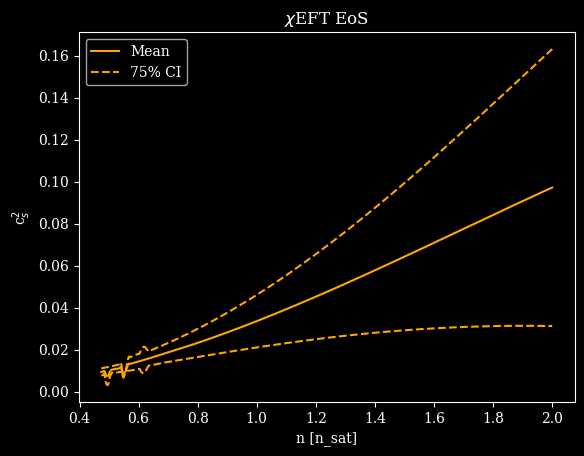

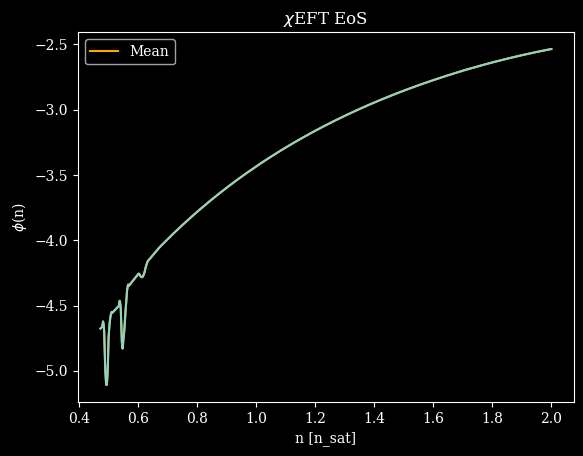

In [16]:
plt.style.use('dark_background')
ax = plt.gca()
ax.set_facecolor('black')
plt.rcParams["font.family"] = "serif"

plt.plot(n_ceft/ns, cs2_ceft_avg, color='orange', label='Mean')

plt.plot(n_ceft/ns, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft/ns, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')



plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
plt.show()

plt.plot(n_ceft/ns, phi_ceft_avg, color='orange',label='Mean')
plt.plot(n_ceft/ns, phi_ceft_lower, "--", color='orange')
plt.plot(n_ceft/ns, phi_ceft_upper, "--", color='orange', label='75% CI')
plt.ylabel(r'$\phi$(n)')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
plt.show()


# lower

In [540]:
stop = 160

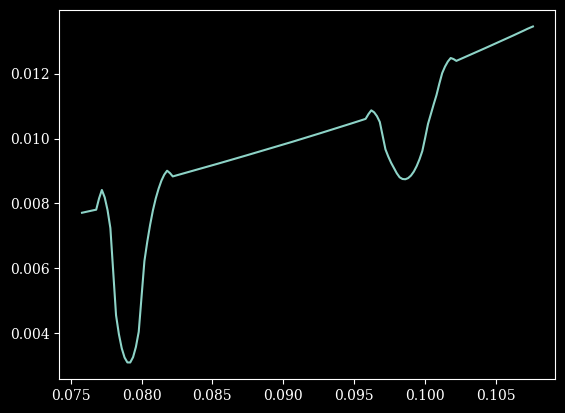

In [541]:
plt.plot(n_ceft[:stop], cs2_ceft_lower[:stop] )
#plt.xlim((0.07,0.11))

filter out 6 (inclusive) to 34 (exclusive)

filter out 101 to 134

smoothing from cs2_ceft[0] until cs2_ceft[140]

In [542]:
cs2_ceft_l_train = np.concatenate((cs2_ceft_lower[0:6], cs2_ceft_lower[34:101], cs2_ceft_lower[134:140]))
n_ceft_l_train = np.concatenate((n_ceft[0:6], n_ceft[34:101], n_ceft[134:140]))
cs2_ceft_l_test = np.concatenate((cs2_ceft_lower[6:34], cs2_ceft_lower[101:134]))
n_ceft_l_test = np.concatenate((n_ceft[6:34], n_ceft[101:134]))

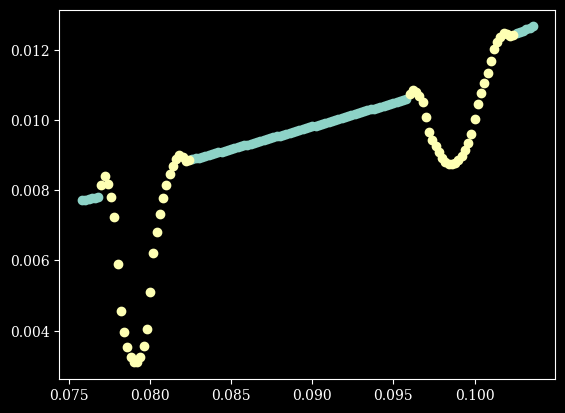

In [543]:
plt.scatter(n_ceft_l_train, cs2_ceft_l_train)
plt.scatter(n_ceft_l_test, cs2_ceft_l_test)

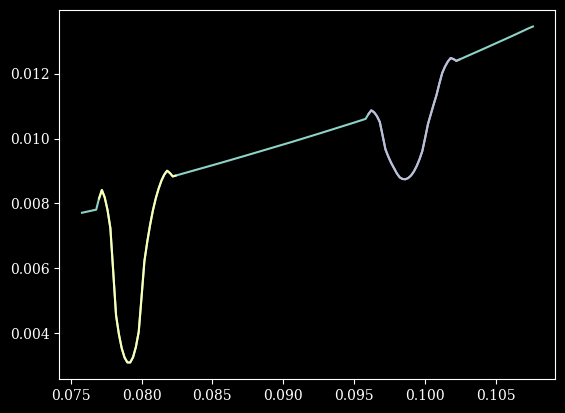

In [544]:
a = 6
b = 34

c = 101
d = 134

plt.plot(n_ceft[:160], cs2_ceft_lower[:160] )
plt.plot(n_ceft[a:b], cs2_ceft_lower[a:b] )
plt.plot(n_ceft[c:d], cs2_ceft_lower[c:d] )


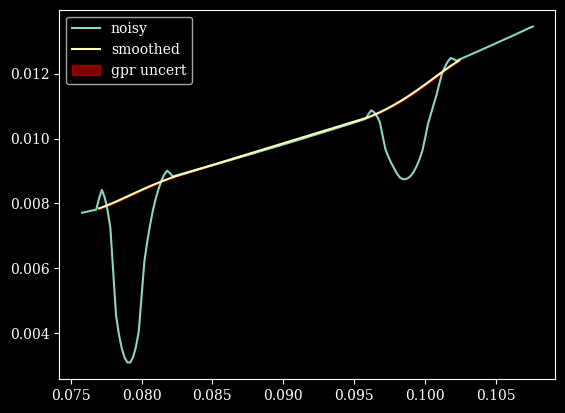

In [545]:
kern = kernels.Kernel('SE', sigma = 0.01, l = 0.01)

gp = gaussianprocess.GP(kern)

gp.fit(n_ceft_l_train, n_ceft_l_test, cs2_ceft_l_train, stabilise=True)

cs2_l_test, sig = gp.posterior()

cs2_l_test = cs2_l_test.flatten()

plt.plot(n_ceft[:stop], cs2_ceft_lower[:stop], label='noisy' )
plt.plot(n_ceft_l_test, cs2_l_test, label = 'smoothed')
plt.fill_between(n_ceft_l_test, cs2_l_test - 1.96 * sig, cs2_l_test + 1.96 * sig, alpha=0.5, color='red', label='gpr uncert')

plt.legend()

In [546]:
cs2_ceft_lower[6:34] = cs2_l_test[:34-6]

cs2_ceft_lower[101:134] = cs2_l_test[34-6:]

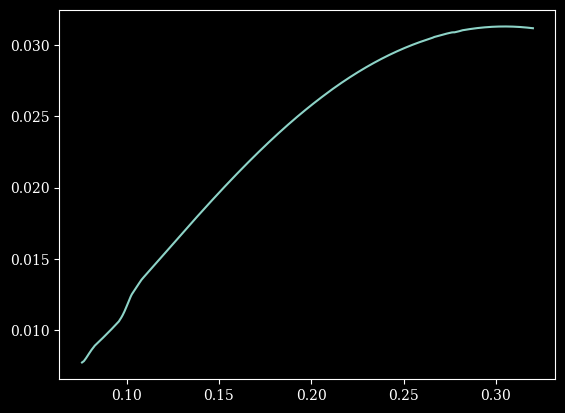

In [547]:
plt.plot(n_ceft, cs2_ceft_lower)

# upper

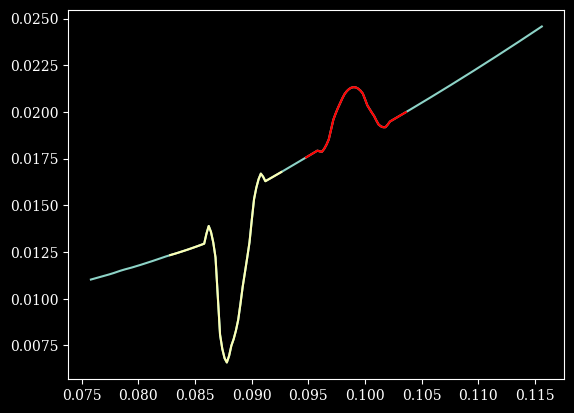

In [548]:
a = 35
b = 85

c = 95
d = 140

end = 200

plt.plot(n_ceft[:end], cs2_ceft_upper[:end] )
plt.plot(n_ceft[a:b], cs2_ceft_upper[a:b])
plt.plot(n_ceft[c:d], cs2_ceft_upper[c:d], color = "red")
plt.show()

In [549]:
cs2_ceft_u_train = np.concatenate((cs2_ceft_upper[0:a], cs2_ceft_upper[b:c], cs2_ceft_upper[d:end]))
n_ceft_u_train = np.concatenate((n_ceft[0:a], n_ceft[b:c], n_ceft[d:end]))

n_ceft_u_test = np.concatenate((n_ceft[a:b], n_ceft[c:d]))

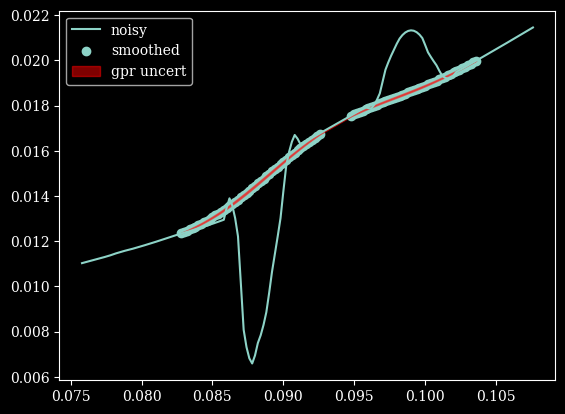

In [550]:
kern = kernels.Kernel('SE', sigma = 0.01, l = 0.01)

gp = gaussianprocess.GP(kern)

gp.fit(n_ceft_u_train, n_ceft_u_test, cs2_ceft_u_train, stabilise=True)

cs2_u_test, sig = gp.posterior()

cs2_u_test = cs2_u_test.flatten()

plt.plot(n_ceft[:stop], cs2_ceft_upper[:stop], label='noisy' )
plt.scatter(n_ceft_u_test, cs2_u_test, label = 'smoothed')
plt.fill_between(n_ceft_u_test, cs2_u_test - 1.96 * sig, cs2_u_test + 1.96 * sig, alpha=0.5, color='red', label='gpr uncert')

plt.legend()

In [551]:
cs2_ceft_upper[a:b] = cs2_u_test[:b-a]

cs2_ceft_upper[c:d] = cs2_u_test[b-a:]

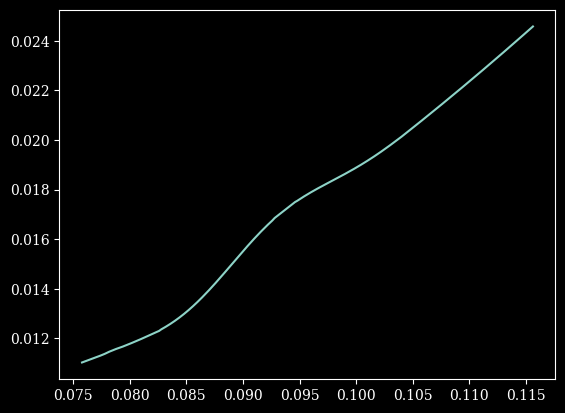

In [552]:
plt.plot(n_ceft[:end], cs2_ceft_upper[:end])

# smoothing function

In [ ]:
def smooth_cs2(cs2_ceft, a,b,c,d):
    
    end = 200
    cs2_ceft_train = np.concatenate((cs2_ceft[0:a], cs2_ceft[b:c], cs2_ceft[d:end]))
    n_ceft_train = np.concatenate((n_ceft[0:a], n_ceft[b:c], n_ceft[d:end]))

    n_ceft_test = np.concatenate((n_ceft[a:b], n_ceft[c:d]))

    kern = kernels.Kernel('SE', sigma = 0.01, l = 0.01)

    gp = gaussianprocess.GP(kern)

    gp.fit(n_ceft_train, n_ceft_test, cs2_ceft_train, stabilise=True)

    cs2_ceft_test, _ = gp.posterior()

    cs2_ceft_test = cs2_ceft_test.flatten()

    new_cs2_ceft = cs2_ceft.copy()

    new_cs2_ceft[a:b] = cs2_ceft_test[:b-a]

    new_cs2_ceft[c:d] = cs2_ceft_test[b-a:]

    return new_cs2_ceft

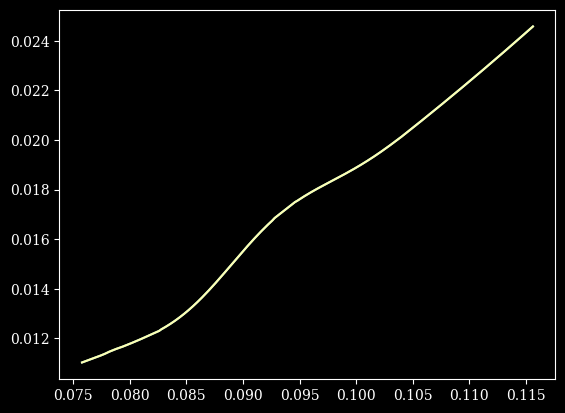

In [554]:
a = 35
b = 85

c = 95
d = 140
plt.plot(n_ceft[:200], cs2_ceft_upper[:200])
plt.plot(n_ceft[:200], smooth_cs2(cs2_ceft_upper, a,b,c,d)[:200])

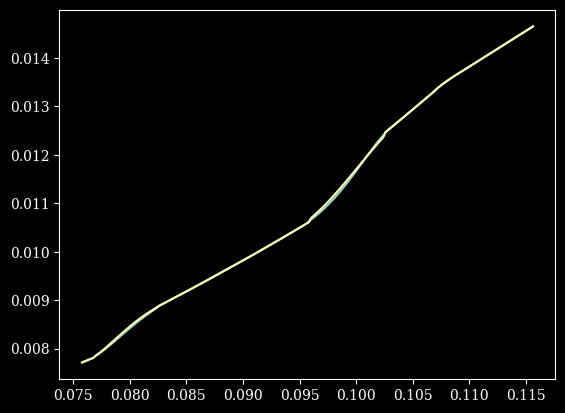

In [555]:
a = 6
b = 34

c = 101
d = 134
plt.plot(n_ceft[:200], cs2_ceft_lower[:200])
plt.plot(n_ceft[:200], smooth_cs2(cs2_ceft_lower, a,b,c,d)[:200])

# smoothed cs2

In [ ]:
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = pc.CI_to_sigma(cs2_ceft_width, 75)

phi_ceft_lower = pp.get_phi(cs2_ceft_lower)
phi_ceft_upper = pp.get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = pc.CI_to_sigma(phi_ceft_width, 75)


In [557]:
print("Each test point correlated to",0.01/np.mean(np.diff(n_ceft)), "points")

Each test point correlated to 50.0 points


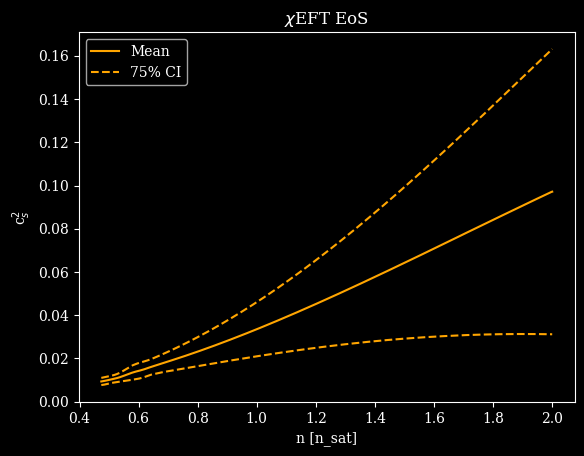

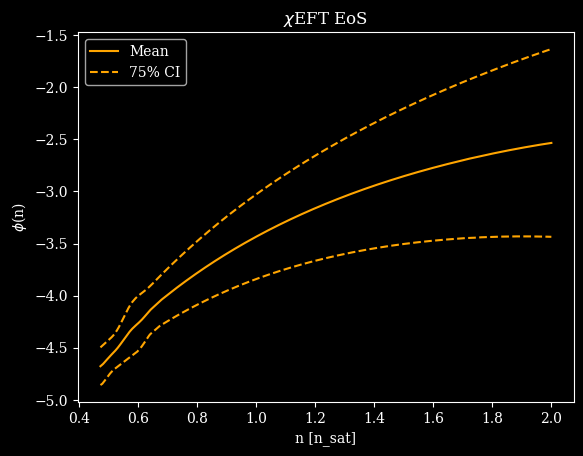

In [558]:
plt.style.use('dark_background')
ax = plt.gca()
ax.set_facecolor('black')
plt.rcParams["font.family"] = "serif"

plt.plot(n_ceft/0.16, cs2_ceft_avg, color='orange', label='Mean')
plt.plot(n_ceft/0.16, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft/0.16, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')
plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
""" plt.xlim(0.4,0.7)
plt.ylim(0,0.04) """
plt.show()

plt.plot(n_ceft/0.16, phi_ceft_avg, color='orange',label='Mean')
plt.plot(n_ceft/0.16, phi_ceft_lower, "--", color='orange')
plt.plot(n_ceft/0.16, phi_ceft_upper, "--", color='orange', label='75% CI')
plt.ylabel(r'$\phi$(n)')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
plt.show()


# ensuring crust connects

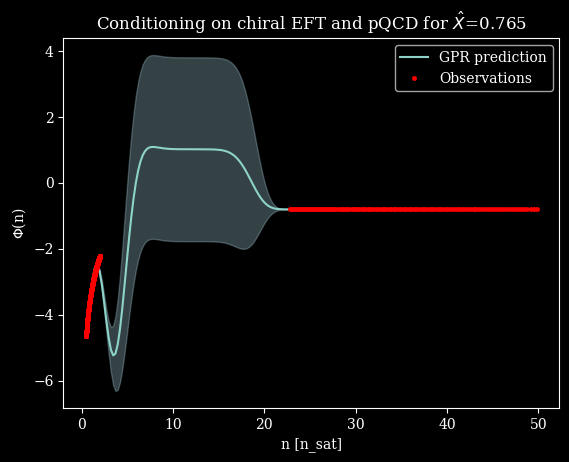

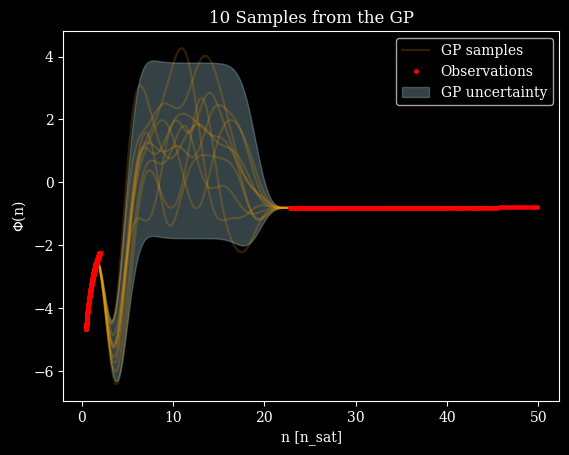

In [ ]:
cs2_hat, nu_hat, l_hat, X_hat = sam.get_hype_samples()

kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_crust[-10:-1]/0.16,n_ceft/0.16, n_pqcd)) #nsat
x_train_nocrust = np.concatenate((n_ceft/0.16, n_pqcd))

cs2_train =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft
cs2_train_nocrust = np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_crust_sigma = np.zeros_like(cs2_crust[-10:-1])

phi_sigma_train = np.concatenate((phi_crust_sigma, phi_ceft_sigma, phi_pqcd_sigma))
phi_train = get_phi(cs2_train)
phi_train_nocrust = get_phi(cs2_train_nocrust)
train_noise = phi_sigma_train**2

x_test = np.linspace((n_ceft/0.16)[0], x_train[-1], 200) # number density in nsat, starting val is ending val of n crust


gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()
phi_test = phi_test.flatten()

plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test, label=f'GPR prediction')
plt.plot(x_train_nocrust, phi_train_nocrust, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sig, phi_test + 1.96 * sig, alpha=0.3, color='lightblue')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
#plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")
plt.title(fr"Conditioning on chiral EFT and pQCD for $\hat X$={X_hat:.3f}")
#plt.plot(n_ceft/0.16, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
#plt.plot(n_ceft/0.16, phi_ceft_avg-phi_ceft_width/2, '--', color='red')

plt.legend()
plt.show()

phi_samples = gp.posterior(sampling=True, n=10)

plt.rcParams["font.family"] = "serif"
plt.plot(x_test, phi_samples[0], color='orange', alpha=0.2, label='GP samples')
for i in phi_samples[1:]:
    plt.plot(x_test, i, color='orange', alpha=0.2)
plt.plot(x_train_nocrust, phi_train_nocrust, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sig, phi_test + 1.96 * sig, alpha=0.3, color='lightblue', label = 'GP uncertainty')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(fr"10 Samples from the GP")
plt.legend()
plt.show()

EOS = eos.EosProperties(x_test*0.16, phi_test, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = EOS.get_all()

In [560]:
n_ceft[0]

0.0758

In [561]:
x_train[9]*0.16

0.0758

In [562]:
x_train_nocrust[0]*0.16

0.0758

In [563]:
x_test[0]*0.16

0.0758

^ last n crust is first n ceft and first n in test set

In [564]:
cs2_train_nocrust[0]

0.00937022810467264

In [565]:
eos_prop_results['cs2'][0]

0.009370038998686533

^ minor diff in gpr cs2 of last crust and actual cs2 of last crust

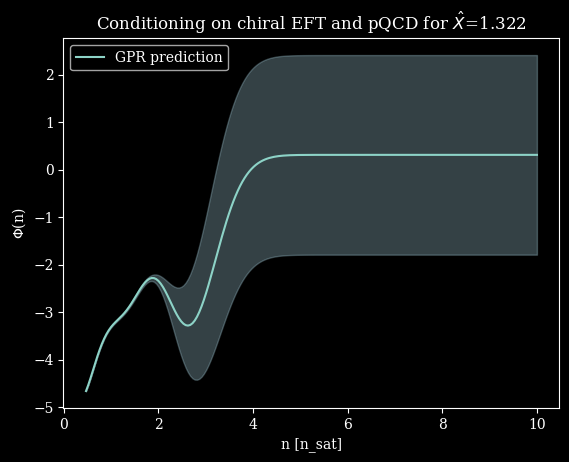

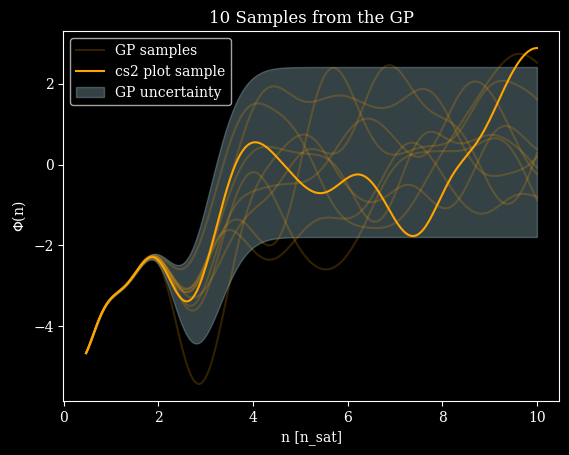

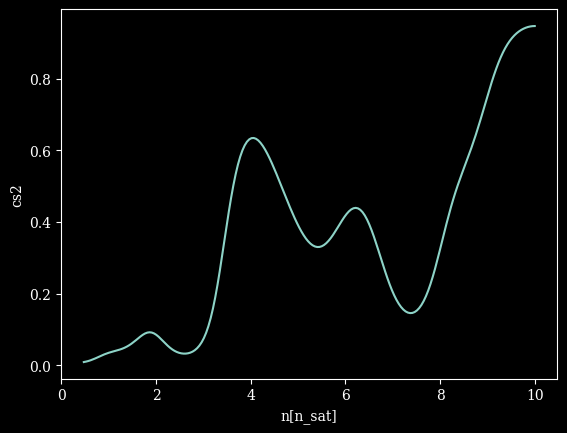

In [ ]:
cs2_hat, nu_hat, l_hat, X_hat = sam.get_hype_samples()

kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_crust[-10:-1]/0.16,n_ceft/0.16, n_pqcd)) #nsat
x_train_nocrust = np.concatenate((n_ceft/0.16, n_pqcd))

cs2_train =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft
cs2_train_nocrust = np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_crust_sigma = np.zeros_like(cs2_crust[-10:-1])

phi_sigma_train = np.concatenate((phi_crust_sigma, phi_ceft_sigma, phi_pqcd_sigma))
phi_train = get_phi(cs2_train)
phi_train_nocrust = get_phi(cs2_train_nocrust)
train_noise = phi_sigma_train**2

x_test = np.linspace((n_ceft/0.16)[0], 10, 200)# number density in nsat, starting val is ending val of n crust; OG end point x_train[-1]


gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()

phi_test = phi_test.flatten()
phi_test[0] = get_phi(cs2_crust[-1]) # minor difference in gpr result and actual crust ending so replacing gpr val


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test, label=f'GPR prediction')
#plt.plot(x_train_nocrust, phi_train_nocrust, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sig, phi_test + 1.96 * sig, alpha=0.3, color='lightblue')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
#plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")
plt.title(fr"Conditioning on chiral EFT and pQCD for $\hat X$={X_hat:.3f}")
#plt.plot(n_ceft/0.16, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
#plt.plot(n_ceft/0.16, phi_ceft_avg-phi_ceft_width/2, '--', color='red')

plt.legend()
plt.show()

phi_samples = gp.posterior(sampling=True, n=10)

plt.rcParams["font.family"] = "serif"
plt.plot(x_test, phi_samples[0], color='orange', alpha=0.2, label='GP samples')
plt.plot(x_test, phi_samples[1], color='orange', label='cs2 plot sample')

for i in phi_samples[2:]:
    plt.plot(x_test, i, color='orange', alpha=0.2)
#plt.plot(x_train_nocrust, phi_train_nocrust, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sig, phi_test + 1.96 * sig, alpha=0.3, color='lightblue', label = 'GP uncertainty')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(fr"10 Samples from the GP")
plt.legend()
plt.show()

EOS = eos.EosProperties(x_test*0.16, phi_samples[1], epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = EOS.get_all()

plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel("n[n_sat]")
plt.ylabel("cs2")
plt.show()

In [567]:
cs2_crust[-1]

0.00937022810467264

In [568]:
eos_prop_results["cs2"][0]

0.009370228104672643

# connecting to pqcd

In [812]:
def smooth_cs2(n_ceft, cs2_ceft, a, b, c, d):
    
    end = 200
    cs2_ceft_train = np.concatenate((cs2_ceft[0:a], cs2_ceft[b:c], cs2_ceft[d:end]))
    n_ceft_train = np.concatenate((n_ceft[0:a], n_ceft[b:c], n_ceft[d:end]))
    n_ceft_test = np.concatenate((n_ceft[a:b], n_ceft[c:d]))

    kern = kernels.Kernel('SE', sigma = 0.01, l = 0.01)
    gp = gaussianprocess.GP(kern)
    gp.fit(n_ceft_train, n_ceft_test, cs2_ceft_train, stabilise=True)

    cs2_ceft_test, _sig = gp.posterior()
    cs2_ceft_test = cs2_ceft_test.flatten()

    new_cs2_ceft = cs2_ceft.copy()
    new_cs2_ceft[a:b] = cs2_ceft_test[:b-a]
    new_cs2_ceft[c:d] = cs2_ceft_test[b-a:]

    return new_cs2_ceft
ns = 0.16
from scipy.stats import loguniform, norm
def get_pqcd(X: float, mu_low: float = 2.2, mu_high:float = 2.8, size: int = 100):
    """
    Retrieve pQCD calculations of number density (in n_sat) and sound speed squared using an X value (renormalisation scale)
    Default mu from 2.2 GeV to 3 GeV
    Returns n_pqcd in nsat units, cs2 unitless
    """

    mu_grid = np.linspace(mu_low, mu_high, size)
        
    pQCD_temp = pQCD(X)
    n_pqcd  = np.vectorize(pQCD_temp.number_density)(mu_grid) /ns # in nsat
    cs2_pqcd = np.vectorize(pQCD_temp.speed2)(mu_grid)
    
    return n_pqcd, cs2_pqcd

def get_hype_samples():
    """
    Hyperparams for GP mean and kernel, as well as pqcd renormalisation scale
    """

    rng = np.random.default_rng()
    nu = rng.normal(1.25, 0.2)
    l = rng.normal(1, 0.5) # note that std here is different than the ones in the qcd papers

    cs2_hat = rng.normal(0.5,0.25)
    while cs2_hat<0 or cs2_hat>1: # sound speed shouldnt be negative or more than c
        cs2_hat = rng.normal(0.5,0.25)        

    X = loguniform.rvs(0.5, 2)


    return cs2_hat, nu, l, X

def get_phi(cs2):
    return -np.log(1/cs2 - 1)

def generate_sample(n_ceft, cs2_ceft_avg, phi_ceft_sigma, n_crust, cs2_crust, x_test_end = 10, mu_low = 2.2, mu_high = 2.8, point_nums=200):
    """
    input n must be in nsat, if used in conjunction with make_condition_eos() that is automatically the case
    out n in nsat
    """

    cs2_hat, nu_hat, l_hat, X_hat = get_hype_samples()

    kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)


    n_pqcd, cs2_pqcd = get_pqcd(X_hat, mu_low, mu_high, size=100) # nsat, unitless

    x_train =  np.concatenate((n_crust[-10:-1]/ns,n_ceft/ns, n_pqcd)) #nsat
    cs2_train =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft

    phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
    phi_crust_sigma = np.zeros_like(cs2_crust[-10:-1])

    phi_sigma_train = np.concatenate((phi_crust_sigma, phi_ceft_sigma, phi_pqcd_sigma))
    phi_train = get_phi(cs2_train)
    train_noise = phi_sigma_train**2

    x_test = np.linspace(n_ceft[0]/ns, x_test_end, point_nums) # number density in nsat, starting val is ending val of n crust, ending val is default 10 nsat


    gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
    gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

    phi_test = gp.posterior(sampling=True)

    phi_test = phi_test.flatten()
    phi_test[0] = get_phi(cs2_crust[-1]) # minor difference in gpr result and actual crust ending so replacing gpr val

    return phi_test, x_test, X_hat, nu_hat, l_hat, cs2_hat

def CI_to_sigma(width, CI):
    """
    TODO: enable the same from any given CI to a sigma value.
    CI: confidence interval percentage (e.g., 75 for 75%)
    """
    z = norm.ppf(1 - (1 - 75/100) / 2)
    sig = width/(2*z)
    return(sig)

def check_pqcd_connection(X_hat, e_end, p_end, n_end):
    pqcd_temp = pQCD(X_hat)
    weight = (int(pqcd_temp.constraints(e0=e_end/1000, p0=p_end/1000, n0=n_end*ns)))
    boolean = weight == 1  
    return boolean



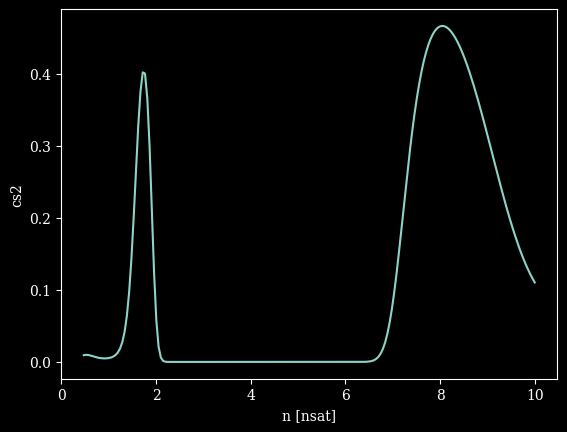

X_hat = 1.6290652037370146
sigma = 1.4376653163890254
 l = 1.439191810939214
C_s^2 = 0.6095413773565459


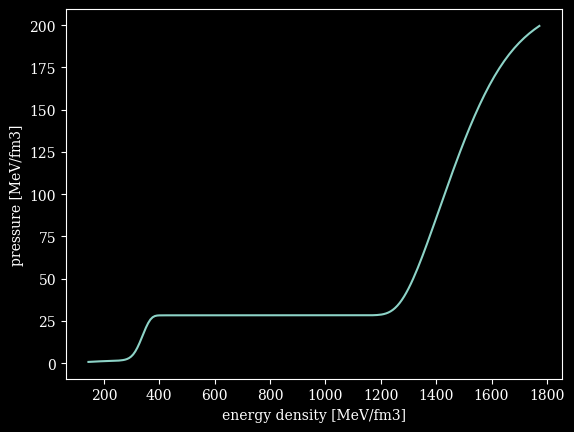

In [846]:
n_end = 10
ceft_path = notebook_dir.parent / 'EOS/ceft'

ceft_lower= np.loadtxt(ceft_path / 'eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt(ceft_path / 'eos_ceft_upper.dat')
_, p_ceft_upper, e_ceft_upper = ceft_upper.T



n_ceft = n_ceft_lower #fm^-3

cs2_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_lower = smooth_cs2(n_ceft, cs2_lower, 6,34,101,134) #getting rid of that dips at beginning of ceft

cs2_upper = np.gradient(p_ceft_upper, e_ceft_upper)
cs2_upper = smooth_cs2(n_ceft, cs2_upper, 35,85,95,140)

cs2_avg = (cs2_upper+cs2_lower)/2

# average CEFT EOS
e_ceft = (e_ceft_lower+e_ceft_upper)/2 # MeVfm^-3 
p_ceft = (p_ceft_lower+p_ceft_upper)/2 # MeVfm^-3

# seperating crust: n_crust = n_ceft[:428] last element overlap
crust_end = 428
n_crust = n_ceft[:crust_end+1]
e_crust = e_ceft[:crust_end+1]
p_crust = p_ceft[:crust_end+1]
cs2_crust = cs2_avg[:crust_end+1]

# seperating ceft proper
p_ceft_upper = p_ceft_upper[crust_end:]
p_ceft_lower = p_ceft_lower[crust_end:]

e_ceft_upper = e_ceft_upper[crust_end:]
e_ceft_lower = e_ceft_lower[crust_end:]

n_ceft = n_ceft[crust_end:]
e_ceft = e_ceft[crust_end:]
p_ceft = p_ceft[crust_end:]

# chemical potential
e_ini = e_ceft[0] 
p_ini = p_ceft[0] 
n_ini = n_ceft[0]
mu_ini = (e_ini + p_ini) / n_ini # MeV

# sound speed
cs2_ceft_lower = cs2_lower[crust_end:]
cs2_ceft_upper = cs2_upper[crust_end:] 
cs2_ceft_avg = cs2_avg[crust_end:]  

# phi
phi_ceft_lower = get_phi(cs2_ceft_lower)
phi_ceft_upper = get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_sigma = CI_to_sigma(phi_ceft_width, 75)

samples_n = 1
NEOS = 0
while NEOS < samples_n:
    phi, n, X_hat, sig_hat, l_hat, cs2_hat = generate_sample(n_ceft, cs2_ceft_avg, phi_ceft_sigma, n_crust, cs2_crust, n_end)
    
    EOS = eos.EosProperties(n, phi, epsi_0=e_ini, p_0=p_ini, mu_0=mu_ini)
    eos_result = EOS.get_all()

    if (check_pqcd_connection(X_hat, eos_result["epsilon"][-1], eos_result["pressure"][-1], n_end)):
        NEOS +=1

plt.plot(n, eos_result["cs2"])
plt.xlabel("n [nsat]")
plt.ylabel("cs2")
plt.show()
print(f"X_hat = {X_hat}\nsigma = {sig_hat}\n l = {l_hat}\nC_s^2 = {cs2_hat}")
plt.plot(eos_result["epsilon"], eos_result["pressure"])
plt.xlabel("energy density [MeV/fm3]")
plt.ylabel("pressure [MeV/fm3]")
plt.show()

# Reason for phase trans at low n

The connection to pQCD is valid 

# more samples